In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.models import model_from_json
from collections import defaultdict
from tqdm import tqdm_notebook

Using TensorFlow backend.


## Load trained models and data

In [2]:
with open('../data/yelp_classification_training.pkl', 'rb') as out:
    training = pickle.load(out)

In [3]:
with open('../data/yelp_classification_experiments.pkl', 'rb') as out:
    saved_models = pickle.load(out)

In [4]:
experiments = {}
for k, v in saved_models.items():
    s = {}
    for model_name, model in v.items():
        if model_name == 'DNN':
            m = model_from_json(model)
            m.load_weights("../data/{}_{}.h5".format(k, model_name))
            s[model_name] = m
        else:
            s[model_name] = model
    experiments[k] = s

## Predict and test

In [5]:
test = 'raw_lemma_tfidf'
_, x_test, _, y_test = training[test]
out = experiments[test]['DNN'].predict(x_test)
print((out.argmax(axis=1) + 1)[:6])

[5 5 5 4 1 5]


## Example

In [6]:
for experiment, models in experiments.items():
    x_train, x_test, y_train, y_test = training[experiment]
    print('TRU', np.array(y_test[:6]))
    for model_name, model in models.items():
        if model_name == 'DNN':
            y_pred = model.predict(x_test).argmax(axis=1) + 1
        else:
            y_pred = model.predict(x_test)
        print(model_name, y_pred[:6])
    break

TRU [1 5 4 4 1 5]
DTC [4 5 1 2 1 5]
KNN [1 1 4 4 3 1]
DNN [1 5 4 4 1 5]


## Get precision and recall

In [7]:
from sklearn.metrics import precision_recall_fscore_support as prfs

### Example

In [8]:
test = 'raw_lemma_tfidf'
_, x_test, _, y_test = training[test]
y_pred = experiments[test]['DTC'].predict(x_test)

In [9]:
prfs(y_test, y_pred, zero_division=0)

(array([0.2892562 , 0.23157895, 0.13761468, 0.33076923, 0.54457831]),
 array([0.31531532, 0.20952381, 0.13636364, 0.33076923, 0.54589372]),
 array([0.30172414, 0.22      , 0.1369863 , 0.33076923, 0.54523522]),
 array([111, 105, 110, 260, 414]))

In [10]:
W = []
P = {}
measures = ['precision', 'recall', 'fscore', 'support']
exp = tqdm_notebook(experiments.items())
for experiment, models in exp:
    x_train, x_test, y_train, y_test = training[experiment]
    predictions = {}
    for model_name, model in models.items():
        if model_name == 'DNN':
            y_pred = model.predict(x_test).argmax(axis=1) + 1
        else:
            y_pred = model.predict(x_test)
        predictions[model_name] = (y_test, y_pred)
        scores = prfs(y_test, y_pred, zero_division=0)
        for j in range(5):
            O = {}
            O['experiment'] = experiment
            O['model'] = model_name
            O['class'] = j + 1
            for i, s in enumerate(measures):
                O[s] = scores[i][j]
            W.append(O)
    P[experiment] = predictions

/home/nick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [11]:
K = pd.DataFrame(W)

In [12]:
K.head()

,experiment,model,class,precision,recall,fscore,support
0,raw_text_tfidf,DTC,1,0.319588,0.258333,0.285714,120
1,raw_text_tfidf,DTC,2,0.191489,0.206897,0.198895,87
2,raw_text_tfidf,DTC,3,0.183206,0.208696,0.195122,115
3,raw_text_tfidf,DTC,4,0.326531,0.325203,0.325866,246
4,raw_text_tfidf,DTC,5,0.579677,0.581019,0.580347,432


## Save

In [13]:
K.to_excel('../data/classification_report.xlsx')
with open('../data/predictions.pkl', 'wb') as out:
    pickle.dump(P, out)

## Load

In [14]:
with open('../data/predictions.pkl', 'rb') as out:
    P = pickle.load(out)
R = pd.read_excel('../data/classification_report.xlsx', index_col=0, header=0)

In [15]:
R.head()

,experiment,model,class,precision,recall,fscore,support
0,raw_text_tfidf,DTC,1,0.319588,0.258333,0.285714,120
1,raw_text_tfidf,DTC,2,0.191489,0.206897,0.198895,87
2,raw_text_tfidf,DTC,3,0.183206,0.208696,0.195122,115
3,raw_text_tfidf,DTC,4,0.326531,0.325203,0.325866,246
4,raw_text_tfidf,DTC,5,0.579677,0.581019,0.580347,432


In [16]:
R[(R.experiment == 'pos_lemma_sentiwn') & (R['class'] == 1)]

,experiment,model,class,precision,recall,fscore,support
135,pos_lemma_sentiwn,DTC,1,0.228571,0.228571,0.228571,105
140,pos_lemma_sentiwn,KNN,1,0.375000,0.457143,0.412017,105
145,pos_lemma_sentiwn,DNN,1,0.500000,0.380952,0.432432,105


In [17]:
R[(R.model == 'DNN') & (R['class'] == 5)]

,experiment,model,class,precision,recall,fscore,support
14,raw_text_tfidf,DNN,5,0.738776,0.837963,0.785249,432
29,raw_lemma_tfidf,DNN,5,0.686391,0.840580,0.755700,414
44,pos_text_tfidf,DNN,5,0.617769,0.776623,0.688147,385
59,pos_lemma_tfidf,DNN,5,0.565943,0.856061,0.681407,396
74,dep_text_tfidf,DNN,5,0.584348,0.807692,0.678103,416
89,dep_lemma_tfidf,DNN,5,0.563272,0.877404,0.686090,416
104,raw_text_sentiwn,DNN,5,0.660617,0.842593,0.740590,432
119,raw_lemma_sentiwn,DNN,5,0.616838,0.867150,0.720884,414
134,pos_text_sentiwn,DNN,5,0.510802,0.859740,0.640852,385
149,pos_lemma_sentiwn,DNN,5,0.499274,0.868687,0.634101,396


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [19]:
def cm(experiment, classifier, predictions):
    yt, yp = predictions[experiment][classifier]
    return ConfusionMatrixDisplay(confusion_matrix(yt, yp), display_labels=range(1,6))

In [20]:
c = cm('raw_text_sentiwn', 'DNN', P)

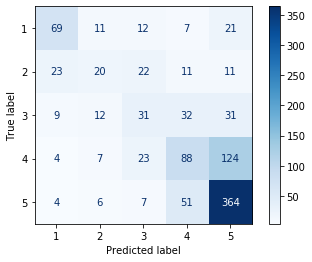

In [21]:
c.plot(values_format=".0f", cmap='Blues')
plt.show()

## Check on polarity

In [22]:
polarity = {}
for experiment, models in P.items():
    polar = {}
    for m, (y_true, y_pred) in models.items():
        yt, yp = [], []
        for x in y_true:
            if x > 3:
                yt.append(1)
            elif x < 3:
                yt.append(-1)
            else:
                yt.append(0)
        for x in y_pred:
            if x > 3:
                yp.append(1)
            elif x < 3:
                yp.append(-1)
            else:
                yp.append(0)
        polar[m] = (yt, yp)
    polarity[experiment] = polar

In [23]:
Z = []
measures = ['precision', 'recall', 'fscore', 'support']
for experiment, models in polarity.items():
    for model_name, (y_true, y_pred) in models.items():
        scores = prfs(y_true, y_pred, zero_division=0)
        for j in range(-1,2):
            O = {}
            O['experiment'] = experiment
            O['model'] = model_name
            O['class'] = j
            for i, s in enumerate(measures):
                O[s] = scores[i][j+1]
            Z.append(O)
Zp = pd.DataFrame(Z)

In [24]:
Zp.head()

,experiment,model,class,precision,recall,fscore,support
0,raw_text_tfidf,DTC,-1,0.424084,0.391304,0.407035,207
1,raw_text_tfidf,DTC,0,0.183206,0.208696,0.195122,115
2,raw_text_tfidf,DTC,1,0.778761,0.778761,0.778761,678
3,raw_text_tfidf,KNN,-1,0.398907,0.705314,0.509599,207
4,raw_text_tfidf,KNN,0,0.251908,0.286957,0.268293,115


In [25]:
Zp[(Zp.model == 'DNN') & (Zp['experiment'] == 'raw_text_combo')]

,experiment,model,class,precision,recall,fscore,support
114,raw_text_combo,DNN,-1,0.746835,0.285024,0.412587,207
115,raw_text_combo,DNN,0,0.363636,0.139130,0.201258,115
116,raw_text_combo,DNN,1,0.755986,0.977876,0.852733,678


In [26]:
c = cm('raw_text_sentiwn', 'DNN', polarity)

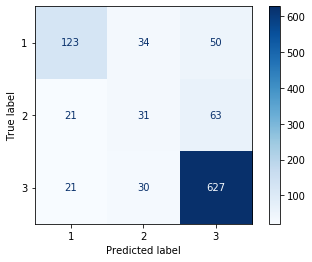

In [27]:
c.plot(values_format=".0f", cmap='Blues')
plt.show()